### Let's implement gridding: 

So what we need first:
- Visibilities
- uv coverage 

Let's import this data first:  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fast_histogram import histogram as fast_hist

In [2]:
fname = "../../HTLup_continuum2.npz"

data = np.load(fname)

# Viewing what we can access from the file: 
print(data.files)

['uu', 'vv', 'weight', 'data']


In [3]:
uu = data["uu"] # kLambda
vv = data["vv"] # kLambda
vis = data["data"] # Jansky 
weight = data["weight"] # = 1/sigma^2

# Including complex conjugates for each visibility
u = np.concatenate([uu, -uu])
v = np.concatenate([vv, -vv])
vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, -vis.imag])
weight = np.concatenate([weight, weight])

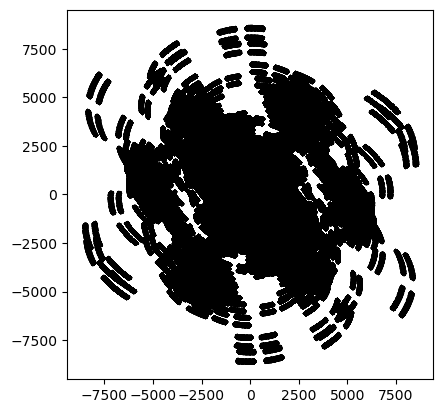

In [4]:
# Plotting the uv coverage: 
plt.scatter(u, v, s = 1.5, rasterized = True, color = "k") # Might take some time since there are a lot of uv points 
plt.gca().set_aspect("equal")

### Grid in image space: 
Let's now define the grid in image space. We need two quantities to do so, a pixel scale $\theta$ (in arcsec) and a number of pixels (that will intrisically define an associated fov). We can basically define the fov as the number of pixels $N$ we want in the grid times our pixel scale: 
$$
\begin{align}
\text{field of view} = N  \theta 
\end{align}
$$
We assume here a square grid (one could apply the same method on a rectangular grid by defining a number of pixels in the x-axis and in the y-axis).

Since MPOL has implemented this same method, here are some the parameters of the grid in image space that should be working with this specific observation:
$$
N = 256  \quad \Delta l = \Delta m =  0.045 \, \text{arcsec} 
$$

Here's a useful relation that will allow us to determine the parameters of the grid in uv space. Because of the definition of the discrete fourier transfom, the pixel scale in uv space is the FOV in image space and inversely.  

$$
\begin{align}
\Delta u = (M\Delta l)^{-1} \quad \Delta v = (N\Delta m)^{-1} \\ 
\\
\Delta l = (M\Delta u)^{-1} \quad \Delta m = (N\Delta v)^{-1}
\end{align}
$$

We just need to be careful of the units (by definition, $l$ and $m$ are in radians)

In [4]:
import mpol.constants as const

npix = 256

pixel_scale = 0.0015 # arcsec
N = npix
M = npix

dl = pixel_scale * const.arcsec # radians 
dm = pixel_scale * const.arcsec # radians

du = 1/(M * dl) * 1e-3
dv = 1/(N * dm) * 1e-3

u_max = M//2 * du
u_min = -M//2 * du

v_max = N//2 * dv
v_min = -N//2 * dv

# We choose to include the left border of the grid
int_u = np.arange(M + 1) - M//2 -0.5
int_v = np.arange(N + 1) - N//2 -0.5

# Physical units for the edges in uv space
u_edges = int_u * du
v_edges = int_v * dv

Text(0, 0.5, 'v [k$\\lambda$]')

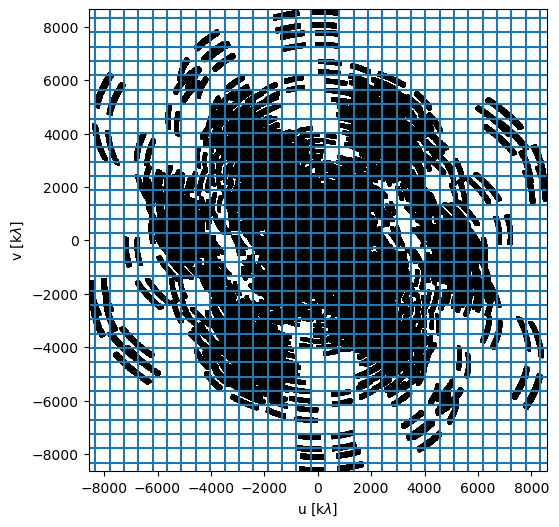

In [6]:
# Plotting the uv coverage: 
figure = plt.figure(figsize = (6, 6))
plt.scatter(u, v, s = 0.5, rasterized = True, color = "k") # Might take some time since there are a lot of uv points 

for i in range(len(u_edges)): 
    plt.axvline(u_edges[i])
    plt.axhline(v_edges[i])

plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")
plt.xlabel(r"u [k$\lambda$]")
plt.ylabel(r"v [k$\lambda$]")

### Grdding the visibilities 

We have a grid in uv space and we are now in position to know which cell contains which visibilities. Now a good question is how are we going to assign a value for each cell in the grid ?

An intuition is to assign a weight $W$ to each visiblity in realtion to their noise level. To do so we could just, for example, define $W_i = \frac{1}{\sigma_i^2}$ the weight for the -ith visibility (where $\sigma_i^2$ is the variance of the gaussian variable of the visibility). We could also take into account the number of visibility points per cell or add a tapering function (function of the radius in uv plane) to upweight/downweight the higher spatial frequencies compared to the smaller spatial frequencies.

We can combine the impact of these different terms with the following equation for the general weight $W$ of a cell: 

$$
W(u, v) = \sum_{k = 1}^{N_\text{vis}} R_k T_k D_k\delta(u-u_k, v-v_k)
$$

where: 
- $R_k$ = thermal noise weight
- $D_k$ = density weighting function (takes account of the number of points in a cell)
- $T_k$ = tapering function

$R_k$ stays the same anyway (just the rescaled weight column in CASA). We take $T_k$ to be one  

NEED TO RECHECK THIS PART

There are different strategies concerning the weighting parameter $D_k$ (according to Briggs phd, it's really like an optimization problem where uniform minimizes the noise $\Delta I_d$ in the dirty image and Natural does something or inversely)  

#### Uniform 

$$
D_k = \frac{1}{\sum_k W_k}
$$

#### Natural 
$$
D_k = 1 
$$


#### Briggs 
$W_k$ is defined as 
$$
D_k = \frac{1}{1 + W_k f^2}
$$
with 

$$
f^2 = \frac{(5 \times 10 ^{-R})^2}{\sum_k W_k ^2 } 
$$


Let's start with the simplest strategy which is the natural weighting.


In [5]:
from mpol import coordinates
from mpol.gridding import DirtyImager

In [6]:
coords = coordinates.GridCoords(cell_size = 0.0015, npix = 256)
imager = DirtyImager(
    coords = coords,
    uu = uu, 
    vv = vv, 
    weight = weight[:len(uu)],
    data_re = vis.real, 
    data_im = vis.imag 
)


In [7]:
# Let's take it slow. 
# First, finding out which visibilities belong to which cell 

index_u = np.digitize(u, u_edges) - 1
index_v = np.digitize(v, v_edges) - 1

In [8]:
def gridded_to_loose(x): 
    return np.array(x[index_u, index_v])

In [9]:
# Summing the weights in each cell, here we have the weight of each cell: 
cell_weight = fast_hist.histogram2d(
            u,
            v,
            bins=npix,
            range=[
                [u_edges.min(), u_edges.max()],
                [v_edges.min(), v_edges.max()],
            ],
            weights=weight,
        )

vis_grid_weight = gridded_to_loose(cell_weight) 

In [42]:
vis_grid_weight.shape

(59597648,)

In [10]:
# uv coverage / sampling function
mask = cell_weight > 0.0

In [35]:
vis.real.mean()

0.022914768302642205

In [34]:
(weight ** -0.5 ).mean()

0.0633726472300745

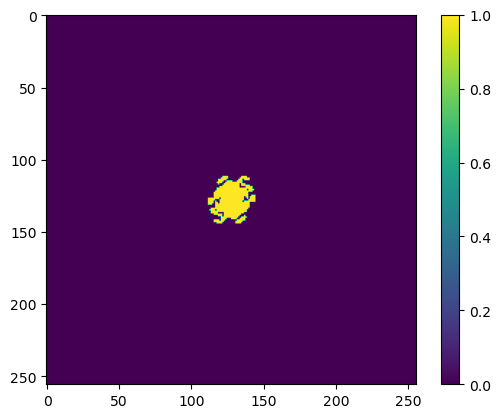

In [11]:
plt.imshow(mask)
plt.colorbar()


Given a list of loose visibility points $(u,v)$ and their corresponding values $`x`$,
partition the points up into 2D $u-v$ cells defined by the ``coords`` object attached to
the gridder, such that ``cell[i,j]`` has bounds between ``coords.u_edges[j, j+1]`` and ``coords.v_edges[i, i+1]``.
Then, sum the corresponding values for each $(u,v)$ point that falls within each cell. The resulting
cell value is

$$
    \mathrm{result}_{i,j} = \sum_k \mathrm{values}_k
$$

where $k$ indexes all $(u,v)$ points that fall within ``coords.u_edges[j, j+1]`` and ``coords.v_edges[i, i+1]``. In the case that all values are :math:`1`, the result is the number of visibilities within each cell (i.e., a histogram).

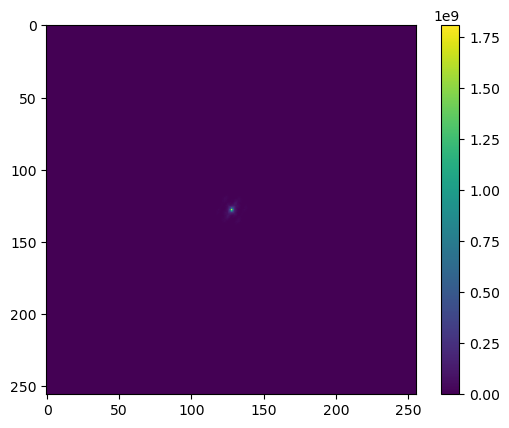

In [19]:
plt.imshow(result)
plt.colorbar()

In [18]:
result.shape

(256, 256)

In [8]:
coords.v_bin_min

-69023.50938216636

In [ ]:
# create the cells as edges around the existing points
# note that at this stage, the UV grid is strictly increasing
# when in fact, later on, we'll need to fftshift for the FFT
cell_weight = imager._sum_cell_values_cube(weight)

: 

: 

In [ ]:


# boolean index for cells that *contain* visibilities
mask = cell_weight > 0.0

# calculate the density weights
# the density weights have the same shape as the re, im samples.
if weighting == "natural":
    density_weight = np.ones_like(weight)
elif weighting == "uniform":
    # cell_weight is (nchan, ncell_v, ncell_u)
    # self.index_v, self.index_u are (nchan, nvis)
    # we want density_weights to be (nchan, nvis)
    density_weight = 1 / _extract_gridded_values_to_loose(cell_weight)

else:
    raise ValueError(
        "weighting must be specified as one of 'natural', 'uniform', or 'briggs'"
    )

# the factor of 2 in the denominator is needed because
# we are approximating the Eqn 3.8 of Briggs' thesis
# we need to sum over the Hermitian quantities in the
# normalization constant.
C = 1 / np.sum(tapering_weight * density_weight * weight, axis=1)

# grid the reals and imaginaries separately
# outputs from _sum_cell_values_cube are *not* pre-packed
data_re_gridded = _sum_cell_values_cube(
    vis_re * tapering_weight * density_weight * weight
)

data_im_gridded = _sum_cell_values_cube(
    vis_imag * tapering_weight * density_weight * weight
)

NameError: name 'imager' is not defined

: 

: 

In [20]:
coords.u_edges.shape

(257,)

In [21]:
u_edges.shape

(257,)

In [23]:
imager.uu.shape

(1, 59597648)

In [19]:
imager.index_u

array([[128, 129, 128, ..., 129, 126, 124]], dtype=int64)

In [4]:
mask_u = np.where(index_u == index_u[0])
mask_v = np.where(index_v == index_v[0])

NameError: name 'u_edges' is not defined

In [58]:
mask_u

(array([       0,        2,        3, ..., 29798809, 29798811, 29798815],
       dtype=int64),)

In [54]:
index_v

array([129, 128, 128, ..., 131, 131, 128], dtype=int64)

In [46]:
first_cell, = np.where(index_u==113)
#plt.scatter(u[])

In [51]:
first_cell

array([ 8523132,  8523873,  8524614, ..., 27778972, 27779709, 27779713],
      dtype=int64)

ValueError: x and y must be the same size

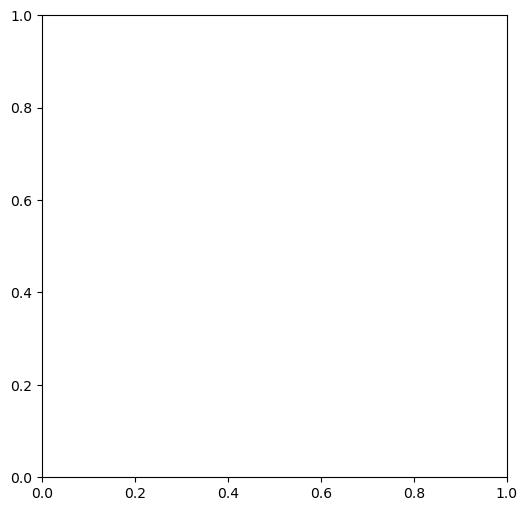

: 

In [60]:
figure = plt.figure(figsize = (6, 6))


plt.scatter(u[mask_u], v[mask_v], s = 0.5, rasterized = True, color = "k") # Might take some time since there are a lot of uv points 

for i in range(len(u_edges)): 
    plt.axvline(u_edges[i])
    plt.axhline(v_edges[i])

plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")
plt.xlabel(r"u [k$\lambda$]")
plt.ylabel(r"v [k$\lambda$]")

In [47]:
len(first_cell)

14224